In [1]:
pip install tensorflow

In [2]:
#Importing required libraries
import os
import shutil
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Importing TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
# Download and extract IMDB dataset
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  17.3M      0  0:00:04  0:00:04 --:--:-- 17.3M


In [4]:
from pathlib import Path

def summarize_imdb_dataset(base_dir="aclImdb", num_files=5):
    base_path = Path(base_dir)
    for split in ["train", "test"]:
        print(f"\nSummary of '{split}' split:")
        for sentiment in ["pos", "neg"]:
            sentiment_path = base_path / split / sentiment
            print(f"  Sentiment: {sentiment}")
            for i, file_path in enumerate(sorted(sentiment_path.iterdir())[:num_files]):
                with file_path.open("r", encoding="utf-8") as f:
                    content = f.readlines()
                print(f"\n  File {i + 1}: {file_path.name}")
                print(f"    Lines in file: {len(content)}")
                print(f"    First 5 lines (or fewer):")
                print("    " + "\n    ".join(content[:5]).strip())


In [5]:
summarize_imdb_dataset()


Summary of 'train' split:
  Sentiment: pos

  File 1: 0_9.txt
    Lines in file: 1
    First 5 lines (or fewer):
    Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!

  File 2: 10000_8.txt
    Lines in file: 1
    First 5 lines (or fewer):
 

In [6]:
from pathlib import Path

batch_size = 32
base_dir = Path("aclImdb")
train_dir = base_dir / "train"
val_dir = base_dir / "val"

for category in ("neg", "pos"):
    category_train = train_dir / category
    category_val = val_dir / category

    category_val.mkdir(parents=True, exist_ok=True)  # Make validation directory if not exist

    files = sorted(category_train.glob("*.txt"))
    random.Random(1337).shuffle(files)

    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]

    for file_path in val_files:
        dest_path = category_val / file_path.name
        if not dest_path.exists():  # Only move if not already moved
            shutil.move(str(file_path), str(dest_path))


In [7]:
from tensorflow import keras

# Use pathlib-based paths (already defined earlier)
train_path = base_dir / "train"
val_path = base_dir / "val"
test_path = base_dir / "test"

# Load datasets using keras.utils.text_dataset_from_directory
train_ds = keras.utils.text_dataset_from_directory(
    directory=str(train_path),
    batch_size=batch_size
)

val_ds = keras.utils.text_dataset_from_directory(
    directory=str(val_path),
    batch_size=batch_size
)

test_ds = keras.utils.text_dataset_from_directory(
    directory=str(test_path),
    batch_size=batch_size
)

# Create a dataset of only the raw text (no labels) from the training set
text_only_train_ds = train_ds.map(lambda x, y: x)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [8]:
from tensorflow.keras import layers

# Set parameters
max_tokens = 10000
max_length = 150

# Create the TextVectorization layer
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length
)

# Adapt the layer on the training text only (no labels)
text_vectorization.adapt(text_only_train_ds)


In [9]:
# Tokenize and map datasets using the vectorizer
# Limit training to 100 samples, keep full val/test unless changed

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).take(100)

int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).take(10000)

int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)


In [10]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense

# Define model input
inputs = Input(shape=(None,), dtype="int64")

# Embedding + Bidirectional LSTM
x = Embedding(input_dim=max_tokens, output_dim=128)(inputs)
x = Bidirectional(LSTM(32))(x)
x = Dropout(0.25)(x)

# Output layer for binary classification
outputs = Dense(1, activation="sigmoid")(x)

# Build the model
embedding_model = Model(inputs, outputs)

# Compile the model
embedding_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Show model architecture
embedding_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,321,281 (5.04 MB)

 Trainable params: 1,321,281 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define callbacks
callbacks = [
    ModelCheckpoint(
        filepath="embedding_model.keras",
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        verbose=1
    )
]


In [12]:
# Train the embedding model
history_embedded = embedding_model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1  # Optional: show training progress per epoch
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4994 - loss: 0.6933
Epoch 1: val_loss improved from inf to 0.68549, saving model to embedding_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.4996 - loss: 0.6933 - val_accuracy: 0.5750 - val_loss: 0.6855
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6330 - loss: 0.6512
Epoch 2: val_loss improved from 0.68549 to 0.61443, saving model to embedding_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.6333 - loss: 0.6509 - val_accuracy: 0.6608 - val_loss: 0.6144
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7910 - loss: 0.4897
Epoch 3: val_loss improved from 0.61443 to 0.49207, saving model to embedding_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.7910 - loss: 0.4896 - val_accuracy: 0.7764 - val_loss: 0.4921
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8501 - loss: 0.3793
Epoch 4: val_loss improved from

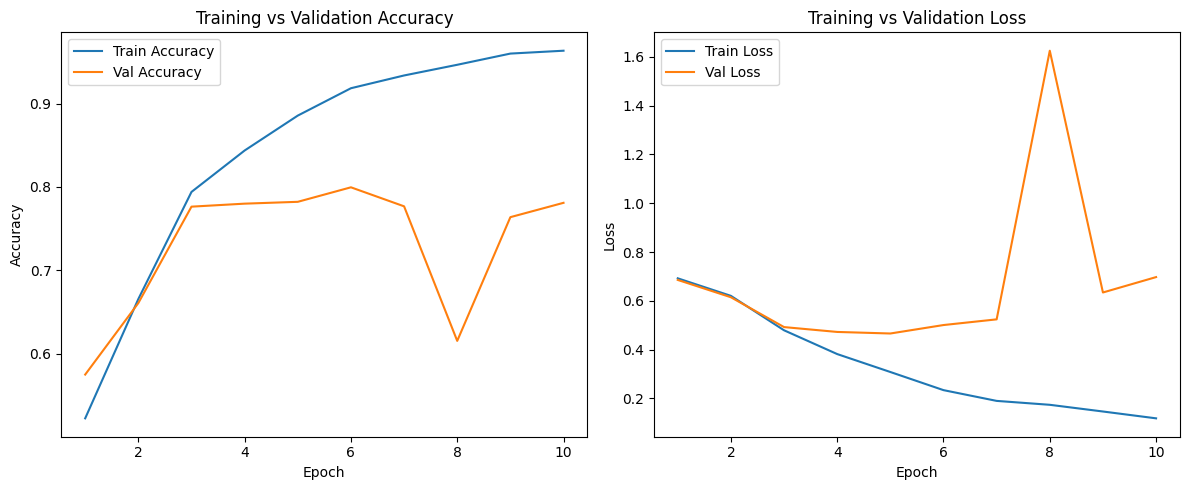

In [13]:
import matplotlib.pyplot as plt

# Get training history
metrics = history_embedded.history
epochs = range(1, len(metrics['accuracy']) + 1)

# Create figure
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, metrics['accuracy'], label='Train Accuracy')
plt.plot(epochs, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, metrics['loss'], label='Train Loss')
plt.plot(epochs, metrics['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)

# Final layout and display
plt.tight_layout()
plt.show()


In [14]:
# Download GloVe embeddings (6B tokens, 100D vectors)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2025-04-08 16:07:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-08 16:07:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-08 16:07:49--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [21]:
import numpy as np

# Set GloVe embedding dimensions and file path
embedding_dim = 100
glove_path = Path("glove.6B.100d.txt")

# Load GloVe word vectors into a dictionary
embeddings_index = {}
with glove_path.open("r", encoding="utf8") as f:
    for line in f:
        word, coefs = line.strip().split(maxsplit=1)
        embeddings_index[word] = np.fromstring(coefs, dtype="f", sep=" ")

# Retrieve vocabulary from the TextVectorization layer
vocabulary = text_vectorization.get_vocabulary()
word_index = {word: i for i, word in enumerate(vocabulary)}

# Prepare embedding matrix
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [22]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.initializers import Constant

# Define the non-trainable embedding layer using GloVe weights
embedding_layer = Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False,
    mask_zero=True  # Optional, useful if padding is used
)

# Build the model using functional API
inputs = Input(shape=(None,), dtype="int64")
x = embedding_layer(inputs)
x = Bidirectional(LSTM(32))(x)
x = Dropout(0.25)(x)
outputs = Dense(1, activation="sigmoid")(x)

# Construct the model
pretrained_model = Model(inputs, outputs)


In [23]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

# Build model using the pretrained embedding layer
inputs = Input(shape=(None,), dtype="int64")
x = embedding_layer(inputs)
x = Bidirectional(LSTM(32))(x)
x = Dropout(0.25)(x)  # Dropout set to 0.25 as you used earlier
outputs = Dense(1, activation="sigmoid")(x)

# Create the model
pretrained_model = Model(inputs, outputs)

# Compile the model
pretrained_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Display the model architecture
pretrained_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 100)      │      1,000,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, None)           │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 64)             │         34,048 │ embedding_2[1][0],     │
│ (Bidirectional)           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             65 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [18]:
# Define the callback to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="pretrained_model.keras",
        save_best_only=True,
        monitor="val_loss",  # Monitor validation loss for best model
        mode="min",  # Save when the validation loss decreases
        verbose=1  # Print when saving the model
    )
]

# Train the pretrained model
history_pretrained = pretrained_model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1  # Display training progress
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5124 - loss: 0.7044
Epoch 1: val_loss improved from inf to 0.64145, saving model to pretrained_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.5127 - loss: 0.7042 - val_accuracy: 0.6508 - val_loss: 0.6415
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6351 - loss: 0.6376
Epoch 2: val_loss improved from 0.64145 to 0.54596, saving model to pretrained_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.6353 - loss: 0.6374 - val_accuracy: 0.7280 - val_loss: 0.5460
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7090 - loss: 0.5685
Epoch 3: val_loss did not improve from 0.54596
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.7091 - loss: 0.5684 - val_accuracy: 0.7024 - val_loss: 0.5702
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7523 - loss: 0.5304
Epoch 4: val_loss improved from 0.54596 to 0.50763, saving model to

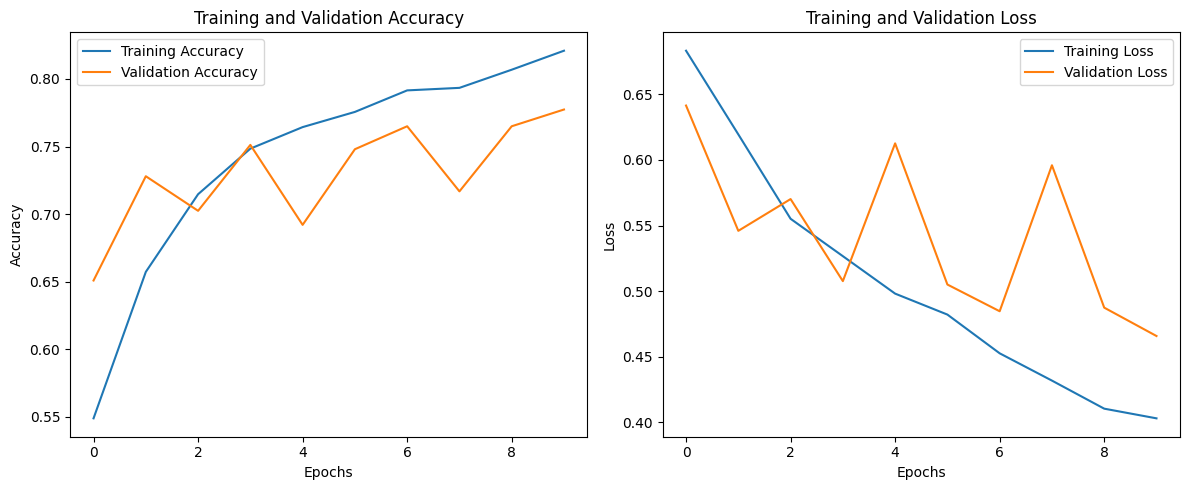

In [19]:
import matplotlib.pyplot as plt

# Extract training history
history_metrics = history_pretrained.history

# Create a figure for the plots
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_metrics['accuracy'], label='Training Accuracy')
plt.plot(history_metrics['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_metrics['loss'], label='Training Loss')
plt.plot(history_metrics['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)

# Display the plots
plt.tight_layout()
plt.show()



### Training with 100 samples ###

Training Custom Embedding Model with 100 samples:
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9765 - loss: 0.0790 - val_accuracy: 0.7712 - val_loss: 0.6051
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9849 - loss: 0.0544 - val_accuracy: 0.7688 - val_loss: 0.6807
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9897 - loss: 0.0468 - val_accuracy: 0.8014 - val_loss: 0.6894
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9907 - loss: 0.0341 - val_accuracy: 0.7942 - val_loss: 0.6689
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9863 - loss: 0.0474 - val_accuracy: 0.8000 - val_loss: 0.6931
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9959 - loss: 0.0167 - val_accuracy: 0.7726 - val_loss: 0.7023
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9957 - loss: 0.0225 - val_accuracy: 0.7936 - val_loss: 0.8173
Epoch 8/10


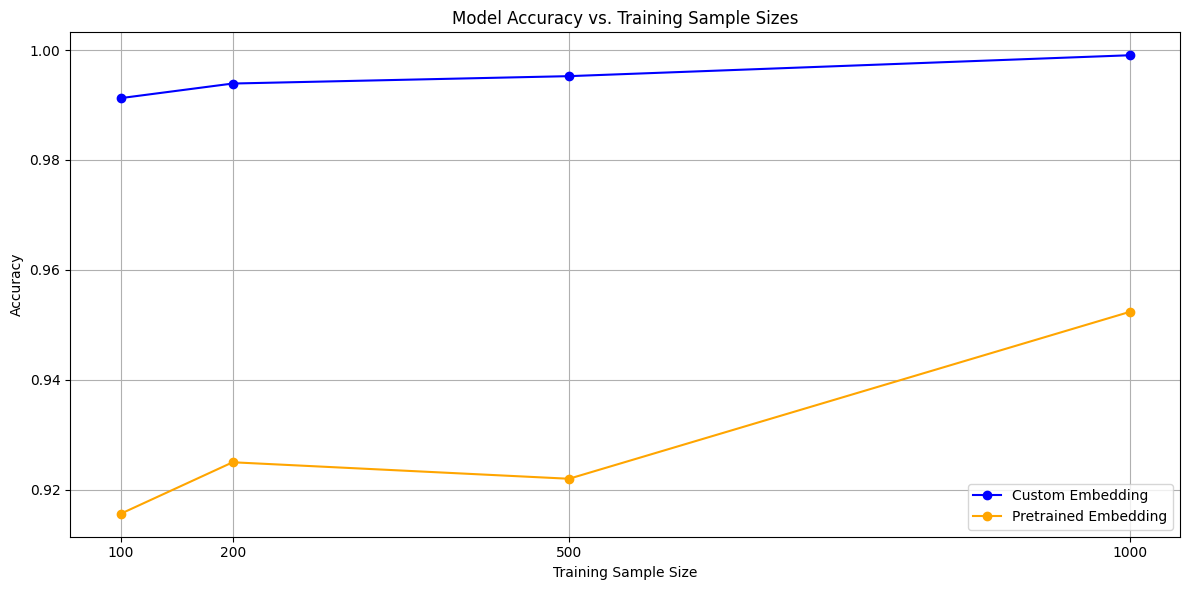

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Data
sample_sizes = [100, 200, 500, 1000]
embedding_accuracies = []
pretrained_accuracies = []

# Initialize the plot
plt.figure(figsize=(12, 6))
plt.title('Model Accuracy vs. Training Sample Sizes')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.grid(True)

# Iterate over sample sizes
for i, size in enumerate(sample_sizes):
    print(f"\n### Training with {size} samples ###\n")

    # Update training dataset with the specific size
    small_train_ds = train_ds.map(
        lambda x, y: (text_vectorization(x), y)).take(size)

    # Train custom embedding model
    print(f"Training Custom Embedding Model with {size} samples:")
    history_embedding = embedding_model.fit(
        small_train_ds,
        validation_data=int_val_ds,
        epochs=10,
        verbose=1
    )
    embedding_acc = history_embedding.history['accuracy'][-1]  # Use the last epoch's accuracy
    embedding_accuracies.append(embedding_acc)
    print(f"Custom Embedding Model Accuracy: {embedding_acc:.4f}\n")

    # Train pretrained embedding model
    print(f"Training Pretrained Embedding Model with {size} samples:")
    history_pretrained = pretrained_model.fit(
        small_train_ds,
        validation_data=int_val_ds,
        epochs=10,
        verbose=1
    )
    pretrained_acc = history_pretrained.history['accuracy'][-1]  # Use the last epoch's accuracy
    pretrained_accuracies.append(pretrained_acc)
    print(f"Pretrained Embedding Model Accuracy: {pretrained_acc:.4f}\n")

    # Update the plot dynamically after each iteration
    if i == len(sample_sizes) - 1:  # Once all iterations are done, plot the final line graph
        plt.plot(sample_sizes, embedding_accuracies, marker='o', label='Custom Embedding', color='blue')
        plt.plot(sample_sizes, pretrained_accuracies, marker='o', label='Pretrained Embedding', color='orange')

# Final plot styling
plt.title('Model Accuracy vs. Training Sample Sizes')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.xticks(sample_sizes)  # Set x-ticks to sample sizes
plt.grid(True)
plt.legend()

# Show the final plot
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd

# Collect results for custom embedding model
custom_embedding_results = {
    "Sample Size": sample_sizes,
    "Custom Embedding Accuracy": embedding_accuracies,
}

# Collect results for pretrained embedding model
pretrained_embedding_results = {
    "Sample Size": sample_sizes,
    "Pretrained Embedding Accuracy": pretrained_accuracies,
}

# Combine both results into a single DataFrame
summary_df = pd.DataFrame({
    "Sample Size": sample_sizes,
    "Custom Embedding Accuracy": embedding_accuracies,
    "Pretrained Embedding Accuracy": pretrained_accuracies
})

# Display the summary of results
print("Summary of Results:")
print(summary_df)

# Optionally save to a CSV file
summary_df.to_csv("embedding_model_accuracy_summary.csv", index=False)


Summary of Results:
   Sample Size  Custom Embedding Accuracy  Pretrained Embedding Accuracy
0          100                   0.991250                       0.915625
1          200                   0.993906                       0.925000
2          500                   0.995250                       0.922000
3         1000                   0.999050                       0.952350


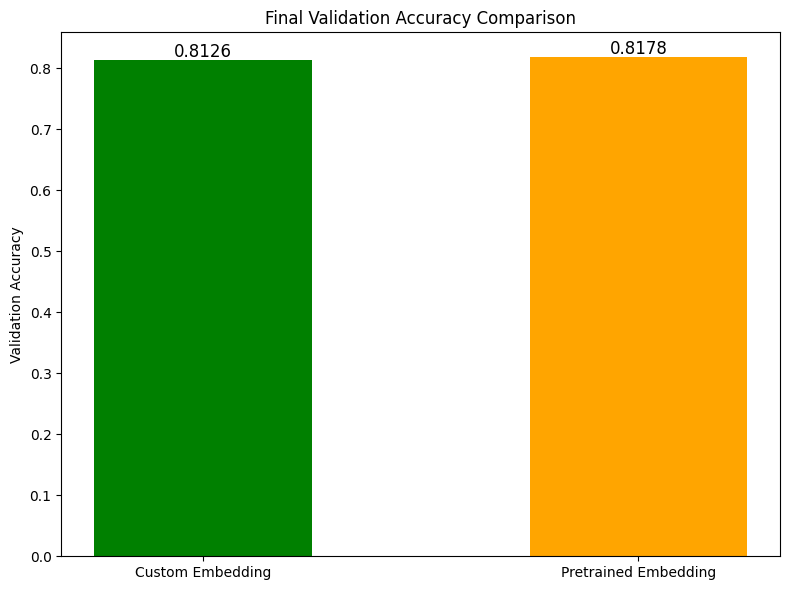

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Data: Models and their corresponding final validation accuracies
models = ['Custom Embedding', 'Pretrained Embedding']
final_val_accuracies = [
    history_embedding.history['val_accuracy'][-1],  # Final validation accuracy for custom embedding
    history_pretrained.history['val_accuracy'][-1]  # Final validation accuracy for pretrained embedding
]

# Bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, final_val_accuracies, color=['green', 'orange'], width=0.5)

# Add labels and title
plt.ylabel('Validation Accuracy')
plt.title('Final Validation Accuracy Comparison')

# Display final values on top of bars
for i, v in enumerate(final_val_accuracies):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


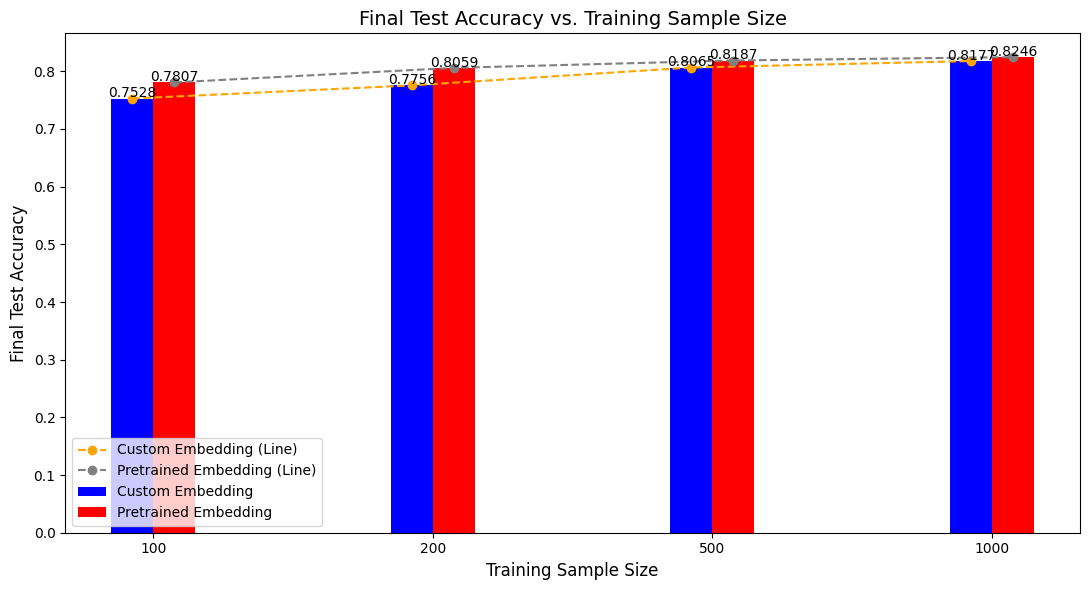

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Data
sample_sizes = [100, 200, 500, 1000]
embedding_accuracies = [0.75280, 0.77556, 0.80652, 0.81772]  # Replace with actual final values
pretrained_accuracies = [0.78072, 0.80588, 0.81868, 0.82456]  # Replace with actual final values

# Bar width and positions
bar_width = 0.15
x_indices = np.arange(len(sample_sizes))  # Base positions for bars

# Plot bars
plt.figure(figsize=(11, 6))
plt.bar(x_indices - bar_width / 2, embedding_accuracies,
        width=bar_width, label='Custom Embedding', color='blue')
plt.bar(x_indices + bar_width / 2, pretrained_accuracies,
        width=bar_width, label='Pretrained Embedding', color='red')

# Overlay lines for comparison
plt.plot(x_indices - bar_width / 2, embedding_accuracies,
         marker='o', color='orange', linestyle='--', label='Custom Embedding (Line)')
plt.plot(x_indices + bar_width / 2, pretrained_accuracies,
         marker='o', color='grey', linestyle='--', label='Pretrained Embedding (Line)')

# Add labels and title
plt.xlabel('Training Sample Size', fontsize=12)
plt.ylabel('Final Test Accuracy', fontsize=12)
plt.title('Final Test Accuracy vs. Training Sample Size', fontsize=14)
plt.xticks(x_indices, sample_sizes)  # Use sample sizes as x-tick labels
plt.legend()

# Annotate bars with final accuracy values
for i in range(len(sample_sizes)):
    plt.text(x_indices[i] - bar_width / 2, embedding_accuracies[i] + 0.002,
             f'{embedding_accuracies[i]:.4f}', ha='center', fontsize=10)
    plt.text(x_indices[i] + bar_width / 2, pretrained_accuracies[i] + 0.002,
             f'{pretrained_accuracies[i]:.4f}', ha='center', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
